# Discord Chat Text Analysis

Analysing the Discord Chat, "66DaysOfData". Channels:#progress and #general

## Importing libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy

from spacy.matcher import PhraseMatcher
from spacy import displacy

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm", disable=['ner'])

import json
import os

%matplotlib inline

In [2]:
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 '66DaysofData - important - general [749395801482199107].json',
 '66DaysofData - important - introductions [749414833275011074].json',
 '66DaysofData - important - progress [749516705734197258].json',
 'progressDiscordChatAnalysis.ipynb',
 'README.md']

## Loading Data

Loading data into dataframes using `.json_normalize()`. I find the `.json` files have more infomation that the `.csv` files.

In [3]:
filename_gen = '66DaysofData - important - general [749395801482199107].json'   # 21-09-2020 NZT #general channel chat
filename_prog = '66DaysofData - important - progress [749516705734197258].json' # 21-09-2020 NZT #progress channel chat
filename_intro = '66DaysofData - important - introductions [749414833275011074].json' # 21-09-2020 NZT #introductions channel chat

def load_json_to_df(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return pd.json_normalize(data, record_path='messages')

df_gen = load_json_to_df(filename_gen)
df_prog = load_json_to_df(filename_prog)
df_intro = load_json_to_df(filename_intro)

## Exploratory Data Analysis - #progress channel

In [4]:
df_prog.shape

(1741, 15)

In [5]:
df_prog.head()

,id,type,timestamp,timestampEdited,callEndedTimestamp,isPinned,content,attachments,embeds,reactions,author.id,author.name,author.discriminator,author.isBot,author.avatarUrl
0,749937010868748351,Default,2020-08-31T10:21:56.547+00:00,None,None,False,Day1: Created a GitHub repo. Created an R and ...,[],[],"[{'emoji': {'id': None, 'name': '💯', 'isAnimat...",715593892438736898,William Guesdon,3961,False,https://cdn.discordapp.com/embed/avatars/1.png
1,750045262277378089,Default,2020-08-31T17:32:05.694+00:00,None,None,False,> Day1: Created a GitHub repo. Created an R an...,[],[],"[{'emoji': {'id': None, 'name': '👍', 'isAnimat...",743513993250996376,Andrew from DataLeap,8501,False,https://cdn.discordapp.com/avatars/74351399325...
2,750067004639281224,Default,2020-08-31T18:58:29.477+00:00,None,None,False,Thank you @Andrew from DataLeap It can definit...,[],[],[],715593892438736898,William Guesdon,3961,False,https://cdn.discordapp.com/embed/avatars/1.png
3,750068015126544485,Default,2020-08-31T19:02:30.396+00:00,None,None,False,"Guys i am a beginner , would appreciate if you...",[],[],[],750065427107020843,vc,3696,False,https://cdn.discordapp.com/embed/avatars/1.png
4,750070203576221857,Default,2020-08-31T19:11:12.163+00:00,None,None,False,"Hi Guys, Started with basic Stat",[],[],[],750069445883461713,Arth,1001,False,https://cdn.discordapp.com/embed/avatars/1.png


In [6]:
df_prog.dtypes

id                      object
type                    object
timestamp               object
timestampEdited         object
callEndedTimestamp      object
isPinned                  bool
content                 object
attachments             object
embeds                  object
reactions               object
author.id               object
author.name             object
author.discriminator    object
author.isBot              bool
author.avatarUrl        object
dtype: object

In [7]:
# Top 10 authors for fun
top10 = df_prog[df_prog['author.isBot']==False]['author.name'].value_counts().head(10)
top10

dsgeek101           47
Ashley.bee          32
15Daniel            25
Wilson              25
Aaron Petry         25
Niven               25
RLChibi             24
nedal               23
_dominiquejames_    22
Saurabh_Joshi       21
Name: author.name, dtype: int64

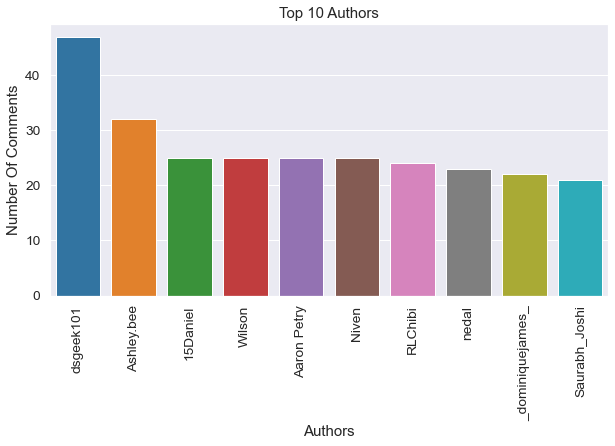

In [8]:
# and graphed... for fun

sns.set_style(style='darkgrid')
sns.set_context('notebook', font_scale=1.25, rc={'lines.linewidth': 2.5})

plt.figure(figsize=(10,5))

ax = sns.barplot(top10.index, top10.values)

labels = ax.set(title='Top 10 Authors',xlabel='Authors', ylabel='Number Of Comments')
ticks = ax.set_xticklabels(ax.get_xticklabels(),rotation=90) # if not assigned to a variable, then prints lots of text

Here we do not want any content from the bot. This gives us random content to look peruse.

In [9]:
content = [_.lower() for _ in df_prog[df_prog['author.isBot']==False]['content']]

import random

random.choices(content, k=30)

['day 5: dug into the conceptual understanding of glms. made a few quick models in statsmodels library of poisson distributed datasets. found resource of general interview statistics questions started work on the questions and created a private repo.',
 'both courses are from datacamp, trying to take advantage that this week is free 😋',
 'day 12: went through telco customer churn on @kaggle.',
 'day 1 #66daysofds - just getting started',
 'd4 #66daysofdata watched a nlp video and discussed an nlp project with my group( created in this community!). finished another chapter of data visualization with tableau course.',
 'day #16 of #66daysofdata. finished pandas micro-course on kaggle.',
 'day 5 - reading chapter2 of hands-on ml and set up a colab to follow the coding exercise along.',
 'day 5 - reading chapter2 of hands-on ml and set up a colab to follow the coding exercise along.',
 'day 5: @66daysofdata\nreading of this  article kind of copying the day 4 of ken jee\nhttps://towardsdata

## Lemmaizing, removing stops words and analysing

In [106]:
# some examples to pick
text1 = 'day 14: went through the first 3 lessons of the deep learning kaggle micro course'
text2 = "day 14: completed kaggle's pandas micro-course"
text3 = '''day 1:  complete the "analyzing police activity with pandas" course on datacamp.'''

#displacy.render(doc, jupyter=True)

for i in random.sample(list(range(len(content))), k=10):
    doc = nlp(content[i])
    noun_list = [token.lemma_ for token in doc if
                not token.is_stop and
                token.pos_ != 'PUNCT']
    output = ' '.join(noun_list)
    print(output)

d8 small datum visualization tableau
totally forget post progress sorry guy day 1 day 6 start finish course statistic r datacamp
day 2 progress finish 3 lesson google introduction tensorflow deep learning start andrew ng deep learning specialization course finish week course exercise fashion mnist dataset classify clothing item image input 

 day 3 goal finish second week course deep learning   specialization assignment exercise project 

 happy learn
day 10&11 read book practical statistic data science specialist
day 15 work 6 python flask server real estate price prediction project codebasic yt channel
day11 linear lagebra basic today udemy course
day 7 # 66daysofdata 
 complete chapter 2 @datacamp data manipulation pandas course sub - setting cumulative function 
 watch episode 19 @kenjeed review data science project ' series 
 order physical copy hand machine learning
continue ml course datacamp machine learn tree base model
day 2 complete matplotlib series youtube teach corey scha

In [105]:
# day matcher

from spacy.matcher import Matcher

pattern_day = [{'LOWER': 'day'},
              {'LIKE_NUM': True}]

matcher = Matcher(nlp.vocab, validate=True)
matcher.add("DayMatcher", None, pattern_day)

for i in random.sample(list(range(len(content))), k=100):
    doc = nlp(content[i])
    days = [doc[start:end] for _, start, end in matcher(doc)]
    print(days)


[]
[]
[day 12]
[day 2]
[day 3]
[day 15]
[day 1/66]
[]
[day 15]
[day 13]
[day 7]
[]
[day 7]
[day 08]
[]
[day 6]
[day 1, day 2]
[day 7]
[]
[day 1]
[day 04]
[day 16]
[]
[day 7/66]
[day 16]
[]
[day 6]
[day 5]
[]
[day 7]
[day 6]
[]
[]
[day 16]
[day 5]
[day 1]
[day 1]
[day 1]
[day 6]
[day 1]
[day 6/66]
[day 9]
[day 1]
[]
[day 8]
[]
[day 12]
[day 9]
[day 10]
[day 2]
[]
[day 4]
[day 14]
[day 1]
[day 2]
[day 3]
[day 2, day 3]
[day 4]
[day 2]
[day 3]
[day 2]
[day 8/66]
[day 8]
[]
[day 3]
[day 2]
[day 1]
[day 8]
[day 9]
[]
[day 11]
[]
[day 7]
[day 5]
[day 4]
[day 3]
[day 9]
[day 8]
[]
[]
[]
[day 17/66]
[day 12]
[day 17]
[]
[day 4]
[]
[day 10/66]
[day 18]
[day 4]
[]
[day 4/66]
[day 3]
[day 8]
[day 1]
[day 1]
[day 2]
[day 3]
[day 5]
[day 11]


## Exploratory Data Analysis - #introductions channel

Find locations and what people do, maybe age as well. Build demographics of the audience

In [77]:
df_intro.shape

(606, 15)

In [ ]:
content_intro = [_ for _ in df_intro[df_intro['author.isBot']==False]['content']]

import random

random.choices(content_intro, k=10)

In [ ]:
df.